# Classifying White Blood Cells

### Introduction

An important problem in blood diagnostics is classifying different types of blood cells. In this notebook, we will attempt to train a classifier to predict the type of a blood cell given a dyed picture of it.

### Data

We have 352 pictures of dyed white blood cells along with labels of what type of blood cell they are. Below is an example of each of the types of blood cells in our dataset.

##### Basophil
![Basophil](Basophil.jpg)

#### Eosinophil
![Eosinophil](Eosinophil.jpg)

#### Lymphocyte
![Lymphocyte](Lymphocyte.jpg)

#### Monocyte
![Monocyte](Monocyte.jpg)

#### Neutrophil
![Neutrophil](Neutrophil.jpg)

### Methodology

We use a simple LeNet architecture trained on 281 training samples with image augmentation. Our augmentation techniques include rotations, shifts, and zooms.

We validate our results against 71 samples.

### Results

We obtain an accuracy of 98.6% on this validation set with the following confusion matrix:

![Confusion Matrix](confusion_matrix.png)


# Code

In [1]:
import numpy as np
#import h5py
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import cv2
import scipy
import os
%matplotlib inline
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# epochs = 20
epochs = 20
BASE_DIR = '../'
batch_size = 32

In [3]:
#model = Sequential()

#model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                 activation ='relu', input_shape = (28,28,1)))
#model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                 activation ='relu'))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Adding Dropouts
    model.add(Dropout(0.05))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Adding Dropouts
    model.add(Dropout(0.05))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Adding Dropouts
    model.add(Dropout(0.05))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Define the optimizer
#     optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#     model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

    return model

In [4]:
model = get_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 57, 77, 32)        0         
__________

In [5]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL', 'EOSINOPHIL']:
                label = 'POLYNUCLEAR'
            else:
                label = 'MONONUCLEAR'
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [6]:
X_train, y_train = get_data(BASE_DIR + 'images/TRAIN/')
X_test, y_test = get_data(BASE_DIR + 'images/TEST_SIMPLE/')

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [ ]:
model = get_model()

# fits the model on batches
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size)

model.save_weights('binary_model.h5')

Train on 7965 samples, validate on 1992 samples
Epoch 1/20
7965/7965 [==============================] - 427s 54ms/step - loss: 0.6814 - acc: 0.6226 - val_loss: 0.8375 - val_acc: 0.0000e+00
Epoch 2/20
7965/7965 [==============================] - 422s 53ms/step - loss: 0.6659 - acc: 0.6277 - val_loss: 0.8742 - val_acc: 0.0000e+00
Epoch 3/20
7965/7965 [==============================] - 426s 53ms/step - loss: 0.6193 - acc: 0.6696 - val_loss: 0.6878 - val_acc: 0.6305
Epoch 4/20
7965/7965 [==============================] - 469s 59ms/step - loss: 0.4787 - acc: 0.7879 - val_loss: 0.7780 - val_acc: 0.4854
Epoch 5/20
3584/7965 [============>.................] - ETA: 3:58 - loss: 0.3805 - acc: 0.8532

# Learning Curve

In [ ]:
#def plot_learning_curve(history):
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./accuracy_curve.png')
plt.clf()
#plot_learning_curve(history)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./loss_curve.png')

# Accuracy

In [28]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.print(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
0.9859154929577465


# Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[ 9  1]
 [ 0 61]]


# Images Misclassified

In [30]:
false_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 0))

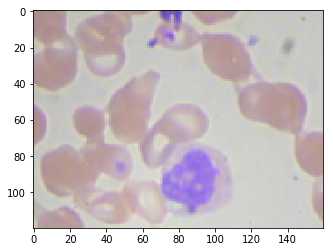

In [48]:
img = X_test[false_positive_mononuclear[0]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Mononuclear Cells Classified Correctly

In [32]:
true_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 1))

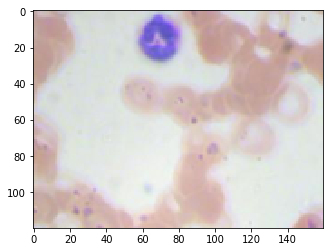

In [33]:
img = X_test[true_positive_mononuclear[0]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

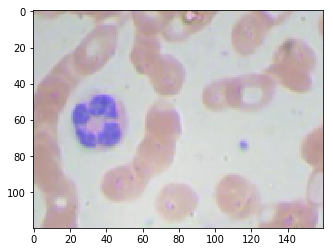

In [34]:
img = X_test[true_positive_mononuclear[5]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

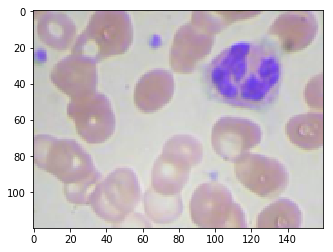

In [35]:
img = X_test[true_positive_mononuclear[8]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Polynuclear Cells Classified Correctly

In [36]:
true_positive_polynuclear = np.intersect1d(np.where(y_pred == 0), np.where(y_test == 0))

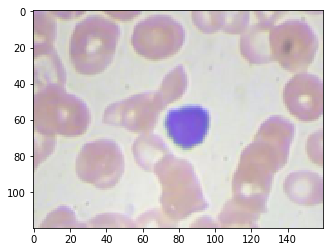

In [40]:
img = X_test[true_positive_polynuclear[8]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

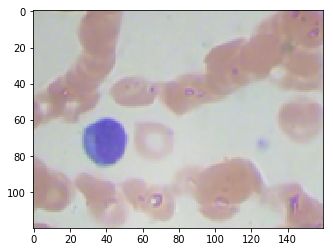

In [44]:
img = X_test[true_positive_polynuclear[4]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

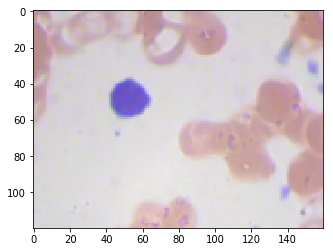

In [45]:
img = X_test[true_positive_polynuclear[3]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))